# A multiple-body problem

Packages needed are NumPy and Matplotlib. 

For the animation bit, the Matplotlib-Jupyter extension (`ipympl`) is used.

This notebook also demonstrates the use of interpolation of the results to create a smoother animation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Set up the variables

This variant uses plain NumPy arrays. The end result will be a three-dimensional array of time, number of particles and state. The inner dimension, state, will be a 4-element array. Using a NumPy array allows for vector-wise addition and multiplication, as well as broadcasting. A nicer variant would have been with structured or record arrays, where the inner dimension would have four elements x, y, u and v, but unfortunately, multiplication of a structured or record array by a single number doesn't work, while this does work for a normal array.

A potential disadvantage is that NumPy arrays aren't ideal when it comes to appending new data (`np.append` works, or depending on the situation, `np.hstack` or `np.vstack`); it would be better if the array could be preallocated, but that requires knowing the number of timesteps beforehand. Which defeats the purposes of using an adaptive timestep algorithm.

The masses are assumed to not change during the simulation, so this is a simple 4-element array. The timestamps are also appended to a standard Python list, then converted to a NumPy array.

In [2]:
state_type = np.dtype([('x', float), ('y', float), ('u', float), ('v', float)])
def make_state(x=0, y=0, u=0, v=0):
    """Simple factory function to return a single state with the correct data type"""
    return np.array([(x, y, u, v)], dtype=state_type)
# Example state
state = make_state(1, 2, 3)
state

array([(1., 2., 3., 0.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('u', '<f8'), ('v', '<f8')])

Write the `center_of_mass` and `energy` functions for the new type of data. This time, these functions will calculate the center of mass and energy for all timesteps in one go. This is obviously slower than for just one timestep, but with some NumPy (vector-wise addition, multiplication, summation, and broadcasting), the code 

In [3]:
from itertools import combinations

def center_of_mass(states, masses):
    """return the center of mass of the system at all timesteps
    """

    total = sum(masses)
    mass_x = (masses[np.newaxis, :] * states[..., 0]).sum(axis=1) / total
    mass_y = (masses[np.newaxis, :] * states[..., 1]).sum(axis=1) / total

    return mass_x, mass_y


def energy(states, masses, G=1):
    """return the energy of the system at all timesteps"""

    # Kinetic energy
    # Inserting an (empty) new axis into masses ensures the masses
    # also get a time dimension, so the calculation applies to
    # each timestamp and each particle. The results are then summed
    # over the inner axis, which is the number of particles
    ke = (0.5 * masses[np.newaxis, :] * (states[...,2]**2 + states[...,3]**2)).sum(axis=1)

    # Potential energy
    # `itertools.combinations` gets all the pairs, without duplication
    pe = sum(-G * masses[i] * masses[j] /
             ((states[:,i,0] - states[:,j,0])**2 +
              (states[:,i,1] - states[:,j,1])**2)**0.5
               for i, j in combinations(range(len(masses)), 2))

    return ke + pe

For reference and testing, below are the parameters for the stable figure-8 three body system.

In [4]:
states0 = np.asarray([
    [-0.97000436, 0.24308753, 0.4662036850, 0.4323657300], 
    [0, 0, -0.93240737, -0.86473146],
    [0.97000436, -0.24308753, 0.4662036850, 0.4323657300],
])
masses = np.ones(3)

Now create a random system of four particles, and calculate the energy and center of mass. Since there is no simulation done yet, only time step 0 is available. All particles have a random x and y position between -1 and 1.

For reproducibility of the example, the random generator seed is set to 1.

In [5]:
rng = np.random.default_rng(1)
states0 = rng.uniform(-1, 1, size=(4, 4))
# Set the velocities to zero
states0[..., [2, 3]] = 0
masses = np.ones(4)
states0, masses

(array([[ 0.02364325,  0.90092739,  0.        ,  0.        ],
        [-0.3763371 , -0.1533471 ,  0.        ,  0.        ],
        [ 0.09918738, -0.94488177,  0.        ,  0.        ],
        [-0.34053657,  0.57685741,  0.        ,  0.        ]]),
 array([1., 1., 1., 1.]))

Calculate the energy and center_of_mass at the start. Note how the `states0` variable is wrapped in an extra array, to add a 1-element time dimension.
As a result, the outputs also contain the time element, of size 1.

In [6]:
energy(np.asarray([states0]), masses)

array([-6.56158693])

In [7]:
center_of_mass(np.asarray([states0]), masses)

(array([-0.14851076]), array([0.09488898]))

## Defining the actual functions

Define the gravitational interaction between the particles.

This returns the derivatives for each particle, each set of derivatives packed together in a `State`.

In [8]:
SMALL = 1e-30  # Fudge factor to prevent division by zero when two particles collide

def gravitate(states, masses, G=1):
    """Calculate the gravitational interacting between particles 
    and return the relevant derivatives

    `states` is a two-dimensional array of shape (number-of-particles, states)
    """

    #states = np.asarray(states).view(np.recarray)
    
    derivs = np.empty_like(states)

    # Iterate over the particles
    for i, state1 in enumerate(states):

        # compute the space derivatives
        dxdt = state1[2]
        dydt = state1[3]

        # compute the velocity derivatives
        dudt = 0.0
        dvdt = 0.0

        # Iterate again over the particles
        for j, state2 in enumerate(states):
            if i == j:
                continue
                
            dx = state2[0] - state1[0]
            dy = state2[1] - state1[1]
            r = dx**2 + dy**2
            r = np.sqrt(r) + SMALL
            dudt += G * masses[j] * dx / r**3
            dvdt += G * masses[j] * dy / r**3
            
        derivs[i, :] = [dxdt, dydt, dudt, dvdt]

    return derivs

Perform a Runge-Kutta step.

Here it is convenient that we can add a `Particle` and a `State`, as well as multiply a `State` by a float (`dt` or `0.5 * dt`).

In [9]:
def step(states, dt, func):
    """Take a single RK-4 timestep from t_n to t_n+`dt` for a set of `particles` interacting in `func`"""

    # Update the derivatives
    derivs1 = func(states)
    
    # Progress by half a time step
    tempstates = states + 0.5 * dt * derivs1
    
    # Update the derivatives by half a time step
    derivs2 = func(tempstates)
    
    # Progress again by half a time step from the start, with new derivatives
    tempstates = states + 0.5 * dt * derivs2

    # Calculate the new derivatives with the second result
    derivs3 = func(tempstates)

    # Proceed a full time step with the new results
    tempparticles = states + dt * derivs3

    derivs4 = func(tempstates)

    # Now do a fully averaged step with all the calculated derivates
    states = states + dt/6 * (derivs1 + 2 * derivs2 + 2 * derivs3 + derivs4)

    return states

Perform a short trial step

In [10]:
from functools import partial

# `partial` allows us to turn `gravitate` into a one-argument function, for given `masses` and `G` arguments
func = partial(gravitate, masses=masses, G=1)
step(states0, 0.01, func)

array([[ 0.02350115,  0.900768  , -0.03411699, -0.03826752],
       [-0.37629649, -0.15328049,  0.00974667,  0.01598868],
       [ 0.0991571 , -0.94481173, -0.00726591,  0.01681084],
       [-0.3404048 ,  0.57688014,  0.03163624,  0.00546799]])

Set up the main integration loop.

An inner loop takes care of ensuring the relative error is smaller than or equal to our error criterion.

In [11]:
from itertools import chain


def integrate(states0, masses, dt, criterion, tmax, func):
    """ integrate the equations of motion using 4th order R-K
    method with an adaptive stepsize, to try to achieve the
    relative error err.  dt here is the initial timestep

    """

    states = [states0]
    timestamps = [0.0]
    
    # safety parameters, from Garcia 2017
    S1 = 0.9
    S2 = 4.0

    # initial conditions
    t = 0.0

    # start with the old timestep
    dt_new = dt

    # number of function evaluations
    neval = 0

    while t < tmax:

        current = states[-1]

        error = 1.e10
        # Loop until `criterion` is reached
        while error > criterion:
            dt = dt_new
            if t + dt > tmax:
                dt = tmax - t

            # take 2 half steps
            tmpstates = step(states[-1], 0.5*dt, func)
            
            twosteps = step(tmpstates, 0.5*dt, func)
            # A single step is 4 function evaluations
            neval += 8
            
            # now take just a single step to cover dt
            onestep = step(states[-1], dt, func)
            neval += 4

            # estimate the maximum relative error
            error = np.nanmax(list(chain.from_iterable([
                [abs((state1[0] - state2[0]) / state1[0]), 
                 abs((state1[1] - state2[1]) / state1[1]),
                 abs((state1[2] - state2[2]) / state1[2]),
                 abs((state1[3] - state2[3]) / state1[3])]
                for state1, state2 in zip(onestep, twosteps)])))

            # adaptive timestep algorithm from Garcia (Eqs. 3.30 and 3.31)
            dt_est = dt * abs(criterion / error)**0.2
            low, high = dt / S2, dt * S2
            dt_new = min(max(S1*dt_est, low), high)

        # successful step
        t += dt

        # set for the next step
        timestamps.append(t)
        states.append(twosteps)

    return np.asarray(timestamps), states, neval

Evaluate the system. The more bodies in the system, the longer this will take.

More importantly, a non-stable system such as this will change the outcome completely depending on the precision: play around with the `criterion`, but be aware that a more precise criterion will result in (far) longer computations (check the number of timestamps).

In [12]:
%%time 

tmax = 1.5

timestamps, states, neval = integrate(states0, masses, dt=1e-2, criterion=1e-4, tmax=tmax, func=func);
states = np.asarray(states)
len(timestamps)

CPU times: user 1.76 s, sys: 22.5 ms, total: 1.78 s
Wall time: 1.77 s


5655

Plot the orbits. This should be quite chaotic. In fact, any tiny change in, say, the criterion value above results in wildly different trajectories.

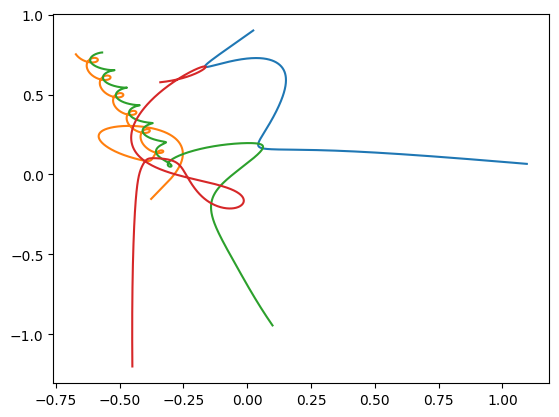

In [13]:
plt.figure()
for i in range(len(masses)):
    x = states[:, i, 0]
    y = states[:, i, 1]
    plt.plot(x, y)

# Animating the orbits

Getting the x and y positions out of the system & particle structure can be a bit tricky.

With the below code, we end up with `x` and `y` variables that are two-dimensional arrays, with the first dimension the number of particles (four in this case), and the second dimension the number of timesteps.

Let's have a look at the timesteps, in particular the intervals. We can use `np.diff` for this on the array of `times`.

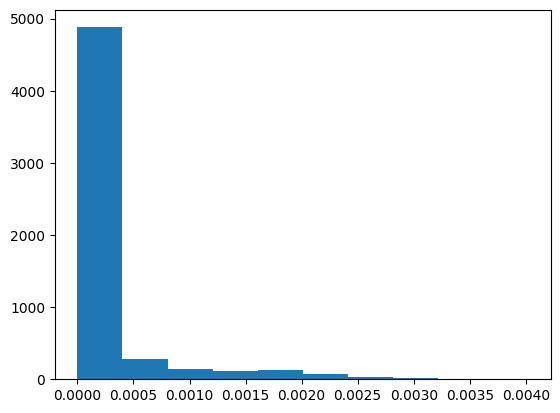

In [14]:
plt.figure()
plt.hist(np.diff(timestamps));

That's definitely not uniform, showing that the solver did use adaptive time steps. The linear scale puts all small values in the same bin, so let's use a log scale to distinguish that a bit better.

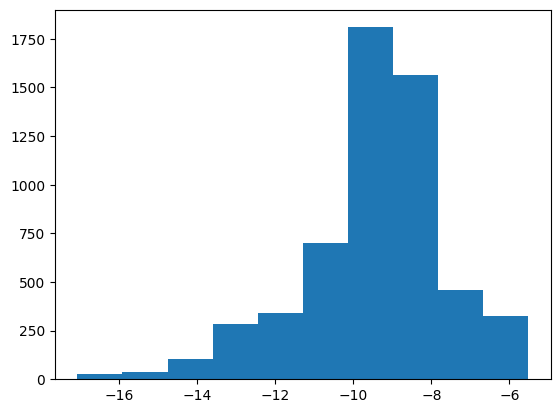

In [15]:
plt.figure()
plt.hist(np.log(np.diff(timestamps)));

If creating an animation with these values, you'll see the animation slowing down and speeding up. It's almost as if the particles pause mid-movement. Notice the time label in the figure, that sometimes appears to even stop (since it only displays to one-thousands).

Notice how most of the slowing down is when particles are close together.

Note: this animation may take quite some time to complete.

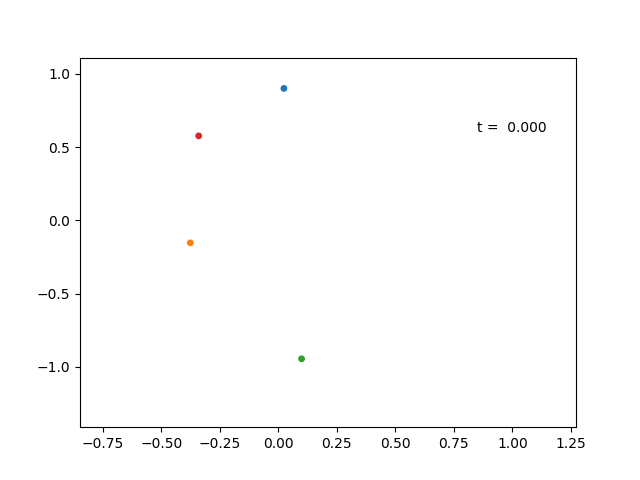

In [16]:
from matplotlib.animation import FuncAnimation

%matplotlib ipympl   


orbits = []
fig = plt.figure()
allx = states[...,0]
ally = states[...,1]
xlimits = np.min(allx), np.max(allx)
dx = xlimits[1] - xlimits[0]
xlimits = xlimits[0] - 0.1 * dx, xlimits[1] + 0.1 * dx
ylimits = np.min(ally), np.max(ally)
dy = ylimits[1] - ylimits[0]
ylimits = ylimits[0] - 0.1 * dy, ylimits[1] + 0.1 * dy
ax = fig.add_subplot(autoscale_on=False, xlim=xlimits, ylim=ylimits)

colors = []
for _ in range(len(masses)):
    orbit, = ax.plot([], [], '-')
    orbits.append(orbit)
    colors.append(orbit.get_color())
# Draw the single particles, with the same colors as the orbits
scatter = ax.scatter(states[0,:,0], states[0,:,1], s=15, c=colors)
text = ax.text(0.8, 0.8, f"t = {timestamps[0]:6.3f}", transform=ax.transAxes)

def animate(i):    
    for j in range(len(masses)):
        orbits[j].set_data(states[max(0, i-500):i,j,0], states[max(0, i-500):i,j,1])
    points = np.vstack([states[i,:,0], states[i,:,1]])
    scatter.set_offsets(points.T)
    text.set_text(f"t = {timestamps[i]:6.3f}")
    
    return orbits + [scatter, text]

anim = FuncAnimation(
    fig, animate, len(timestamps), interval=20, blit=True, repeat=False)

To avoid this slowing down and speeding up, we can fix the times to a linear grid. Then we'll need to interpolate the x and y values of each particle to this grid. This is a simple linear interpolation, and we'll use `np.interp` for this. This needs the grid on which to interpolate, the original times values and the original x and y values to calculate the interpolated x and y values.

This can also be used in cases where there are a lots of timestamps, and plotting each of those in an animation would take far too long.

Since `interp` only works on one-dimensional arrays, we separate the x and y coordinates and iterate in a list comprehension over the number of particles. The tranpose (`states[...,0].T`) is there so that the first index is the particle-index for the list comprehension, and `xx` and `yy` are the data corresponding to each timestamp.

In [17]:
nsteps = 500
assert nsteps <= len(timestamps)
times_int = np.linspace(min(timestamps), max(timestamps), nsteps)
x_int = np.asarray([np.interp(times_int, timestamps, xx) for xx in states[...,0].T])
y_int = np.asarray([np.interp(times_int, timestamps, yy) for yy in states[...,1].T])

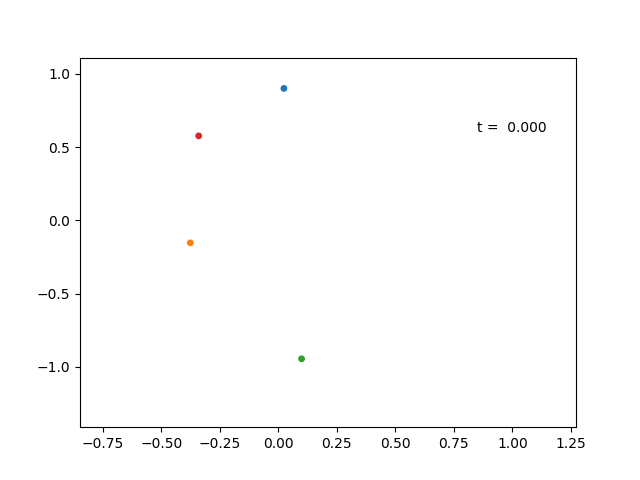

In [18]:
orbits = []
fig = plt.figure()
allx = np.hstack(x_int)
ally = np.hstack(y_int)
xlimits = min(allx), max(allx)
dx = xlimits[1] - xlimits[0]
xlimits = xlimits[0] - 0.1 * dx, xlimits[1] + 0.1 * dx
ylimits = min(ally), max(ally)
dy = ylimits[1] - ylimits[0]
ylimits = ylimits[0] - 0.1 * dy, ylimits[1] + 0.1 * dy
ax = fig.add_subplot(autoscale_on=False, xlim=xlimits, ylim=ylimits)

colors = []
for _ in range(len(x_int)):
    orbit, = ax.plot([], [], '-')
    orbits.append(orbit)
    colors.append(orbit.get_color())
# Draw the single particles, with the same colors as the orbits
scatter = ax.scatter(x_int[:,0], y_int[:,0], s=15, c=colors)
text = ax.text(0.8, 0.8, f"t = {times_int[0]:6.3f}", transform=ax.transAxes)

def animate(i):    
    for j, (xl, yl) in enumerate(zip(x_int, y_int)):
        orbits[j].set_data(xl[max(0, i-50):i], yl[max(0, i-50):i])
    points = np.vstack([x_int[:,i], y_int[:,i]])
    scatter.set_offsets(points.T)
    text.set_text(f"t = {times_int[i]:6.3f}")
    
    return orbits + [scatter, text]

anim = FuncAnimation(
    fig, animate, len(x_int[0]), interval=10, blit=True, repeat=False)

Another solution to avoid plotting these adaptive timesteps, is to not store all the time steps, but only those at regular intervals. An advantage is that it requires less memory to store the relevant data. The disadvantage is that you can't change the timestep scaling after the fact, and the times stored will not exactly match a regular interval.

For this, the `integrate` function needs to be changed. It would need to accept a linear set of time steps, and then store a solution only when the next of those time steps has passed.

In outline, it would look something like:

The energy is definitely not conserved! Possibly, our criterion of 1e-4 was too loose.

The jumps in energy occur when two particles interact closely.

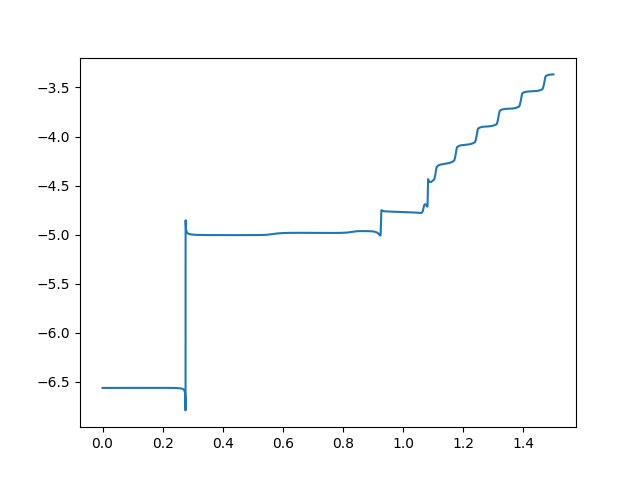

In [19]:
plt.figure()
plt.plot(timestamps, energy(states, masses));